In [191]:
import torch
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

In [192]:
DELTA = 1e-7
EPS = 1e-3

Функции для отрисовки

In [193]:
def draw_f(f):
    t = np.linspace(-4, 4, 1000)
    X, Y = np.meshgrid(t, t)
    ax = plt.subplot(111, projection='3d')
    ax.plot_surface(X, Y, f([X, Y]), linewidth=0, antialiased=True, cmap='terrain')
    plt.show()


def draw_level_lines(f, plot, points, left=-2, right=2, title=""):
    t = np.linspace(left, right, 1000)
    X, Y = np.meshgrid(t, t)
    points = np.array(points)
    plot.plot(points[:, 0], points[:, 1], 'o-')
    levels = np.unique(np.around(f(points.T)))
    plot.contour(X, Y, f([X, Y]), levels=levels)
    plot.title(f"{title}\nIterations: {len(points)}.\nResult: {points[-1]}", color='black')
    plot.grid()


### Сравнение BFGS

В данном сравнении мы рассмотрим написанный BFGS и библиотечный из scipy.optimize.minimize для поиска минимума функции.

#### BFGS из 3-й лабораторной

In [194]:
def bfgs(f, grad_f, start, max_epoch=1000, tol=EPS):
    N = len(start)
    I = np.identity(N)
    points = np.zeros((max_epoch, N))
    points[0] = start

    H = I
    gr = grad_f(start)
    point = start.copy()
    i = 1
    while i < max_epoch:
        p = -np.dot(H, gr)
        alpha = opt.line_search(f, grad_f, point, p, maxiter=100)[0]

        points[i] = point + alpha * p
        s = points[i] - point
        point = points[i]

        gr_point = grad_f(point)
        y = gr_point - gr
        gr = gr_point

        i += 1
        if np.linalg.norm(gr, 2) < tol:
            break

        rho = 1.0 / (np.dot(y, s))
        H = np.dot(I - rho * s[:, np.newaxis] * y[np.newaxis, :], H)
        H = np.dot(H, I - rho * y[:, np.newaxis] * s[np.newaxis, :])
        H = H + rho * s[:, np.newaxis] * s[np.newaxis, :]

    return points[:i]

Градиент через численное дифференцирование

In [195]:
def numdiff(f, x, i, delta=DELTA):
    plus_delta = x.copy()
    plus_delta[i] += delta
    minus_delta = x.copy()
    minus_delta[i] -= delta
    return (f(plus_delta) - f(minus_delta)) / (2 * delta)


def gradient(f):
    return lambda x: np.array([numdiff(f, x, i) for i in range(len(x))])

#### Исследуем для функции Розенброка

$$f(x,y)=(1-x)^2+100(y-x^2)^2$$

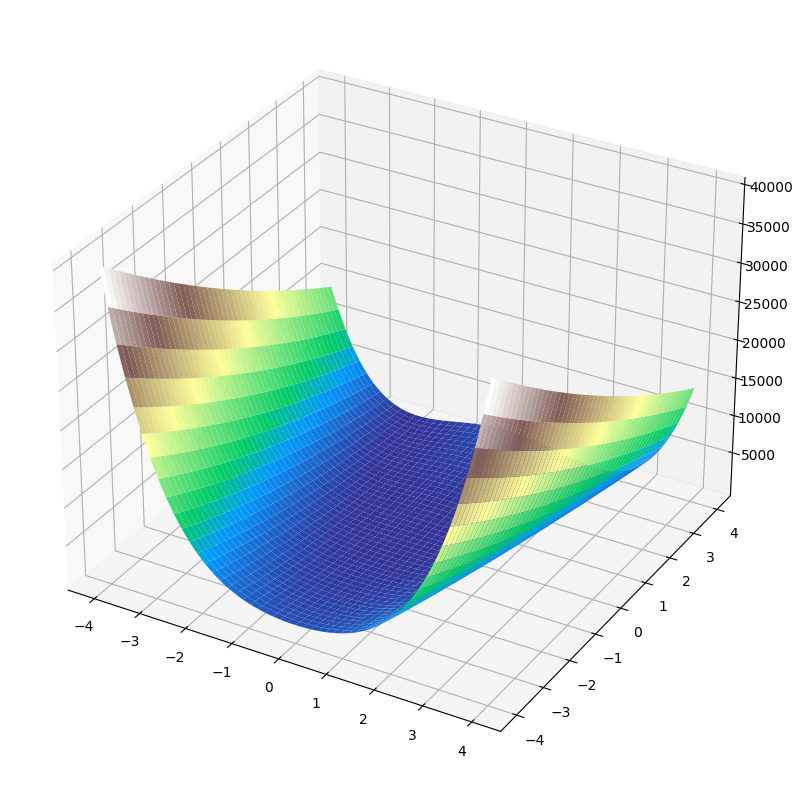

In [196]:
def ros(x):
    return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2


numdiff_ros_grad = gradient(ros)
draw_f(ros)


Начальная точка

In [197]:
x0 = [-0.5, -0.5]

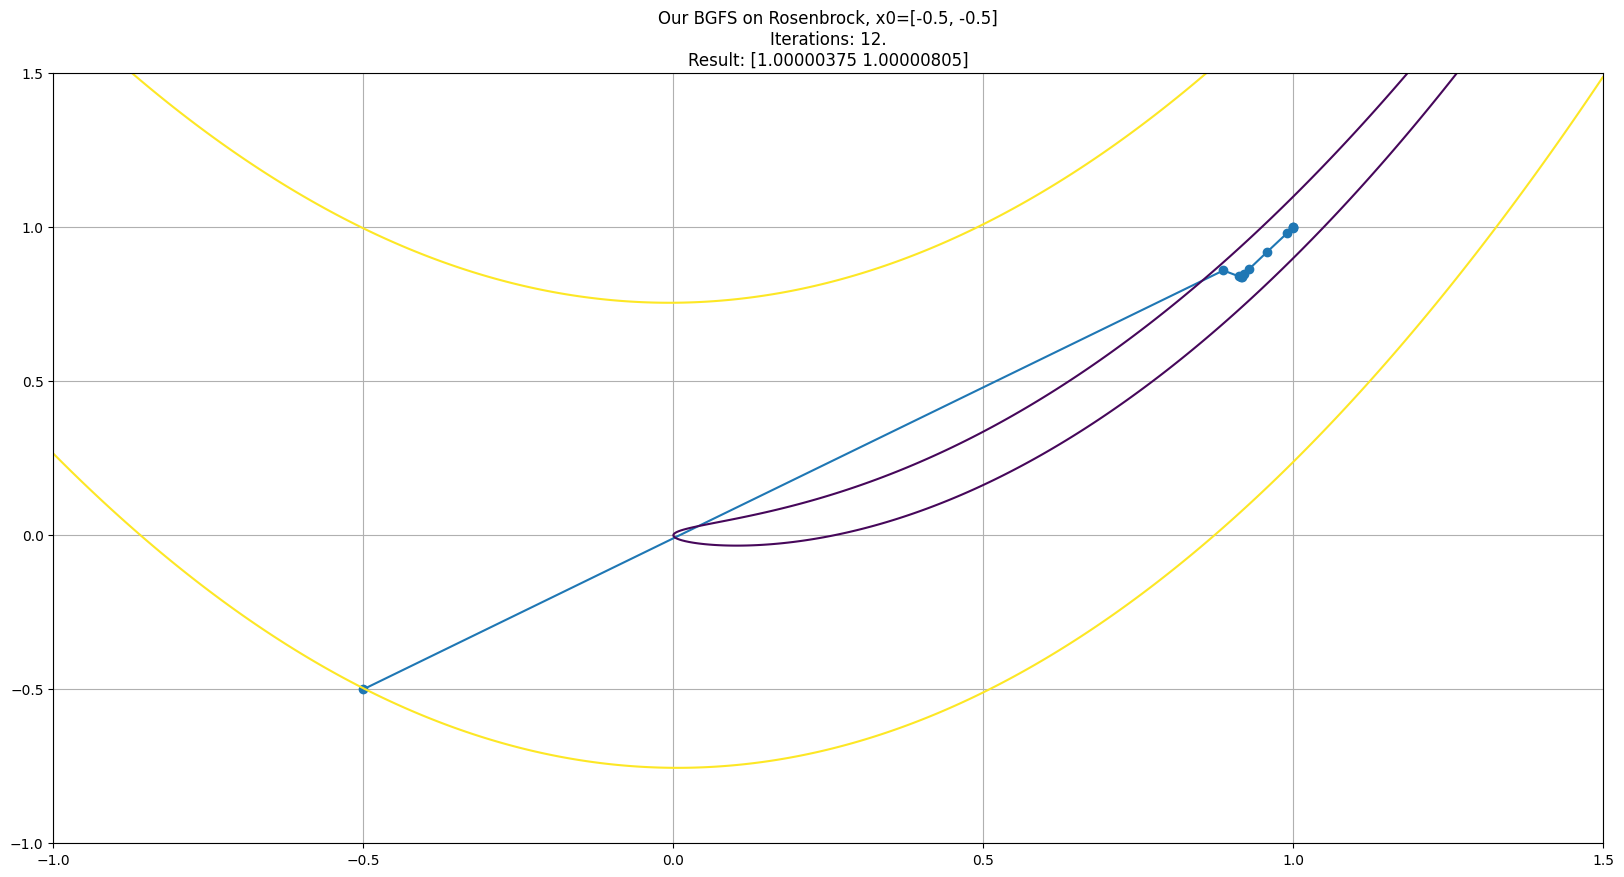

In [198]:
our_bgfs_points = bfgs(ros, numdiff_ros_grad, x0)
draw_level_lines(ros, plt, our_bgfs_points, left=-1, right=1.5, title=f"Our BGFS on Rosenbrock, x0={x0}")

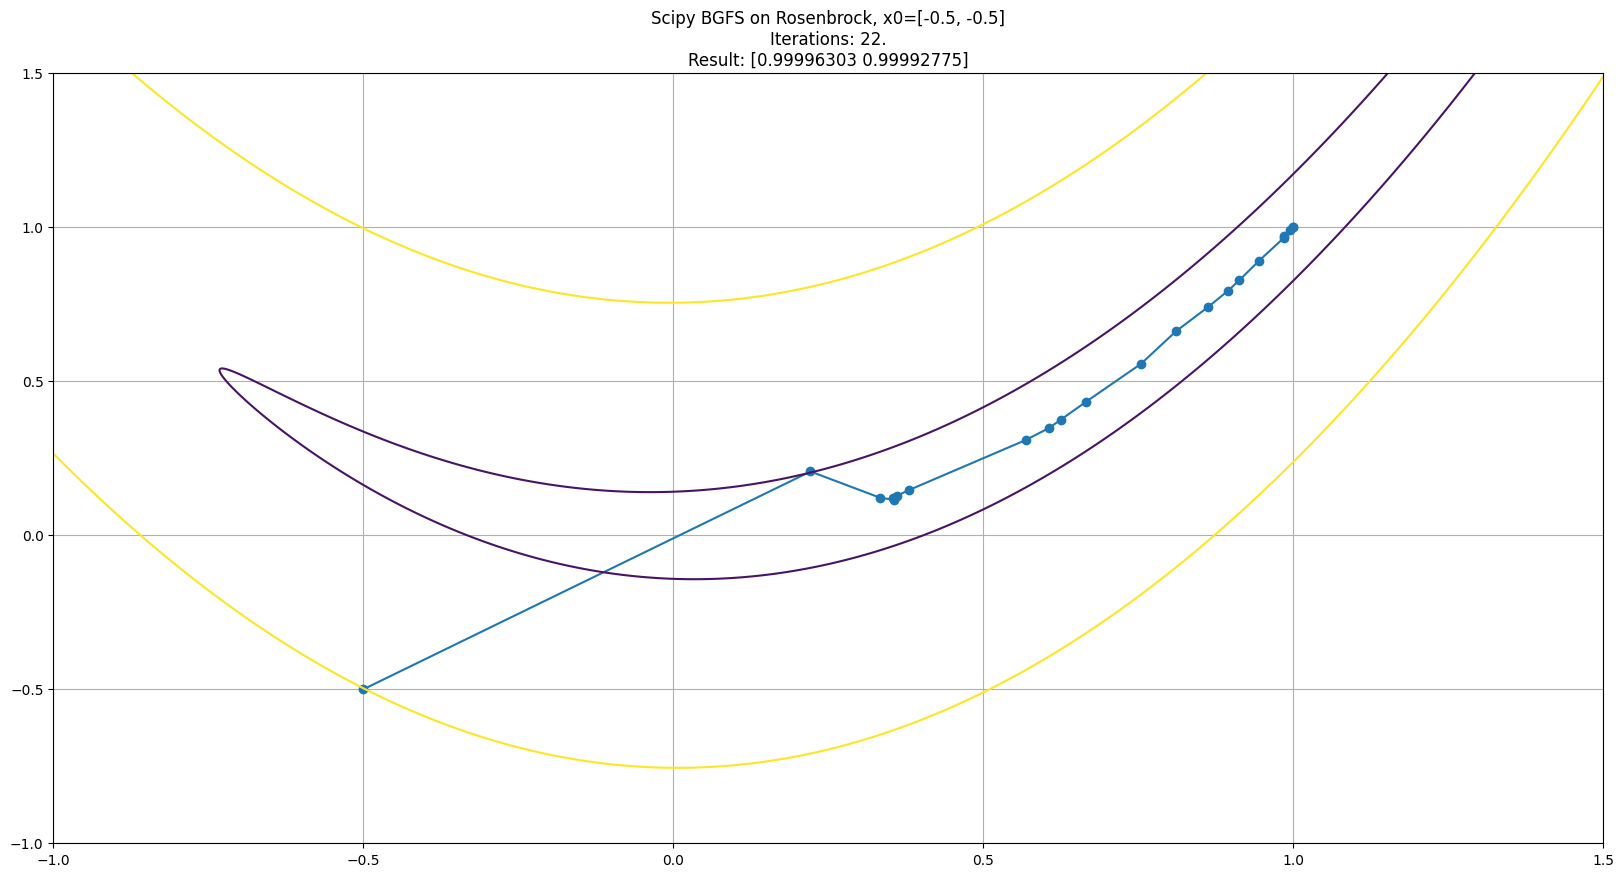

In [199]:
sci_bgfs_points = [x0]
opt.minimize(method='BFGS', fun=ros, jac=numdiff_ros_grad, x0=x0, tol=EPS,
             callback=lambda p: sci_bgfs_points.append(p))
draw_level_lines(ros, plt, sci_bgfs_points, left=-1, right=1.5, title=f"Scipy BGFS on Rosenbrock, x0={x0}")

Наш метод сошелся в 2 раза быстрее.
Отодвинем начальную точку

In [200]:
x0 = [-1.1, -1.1]

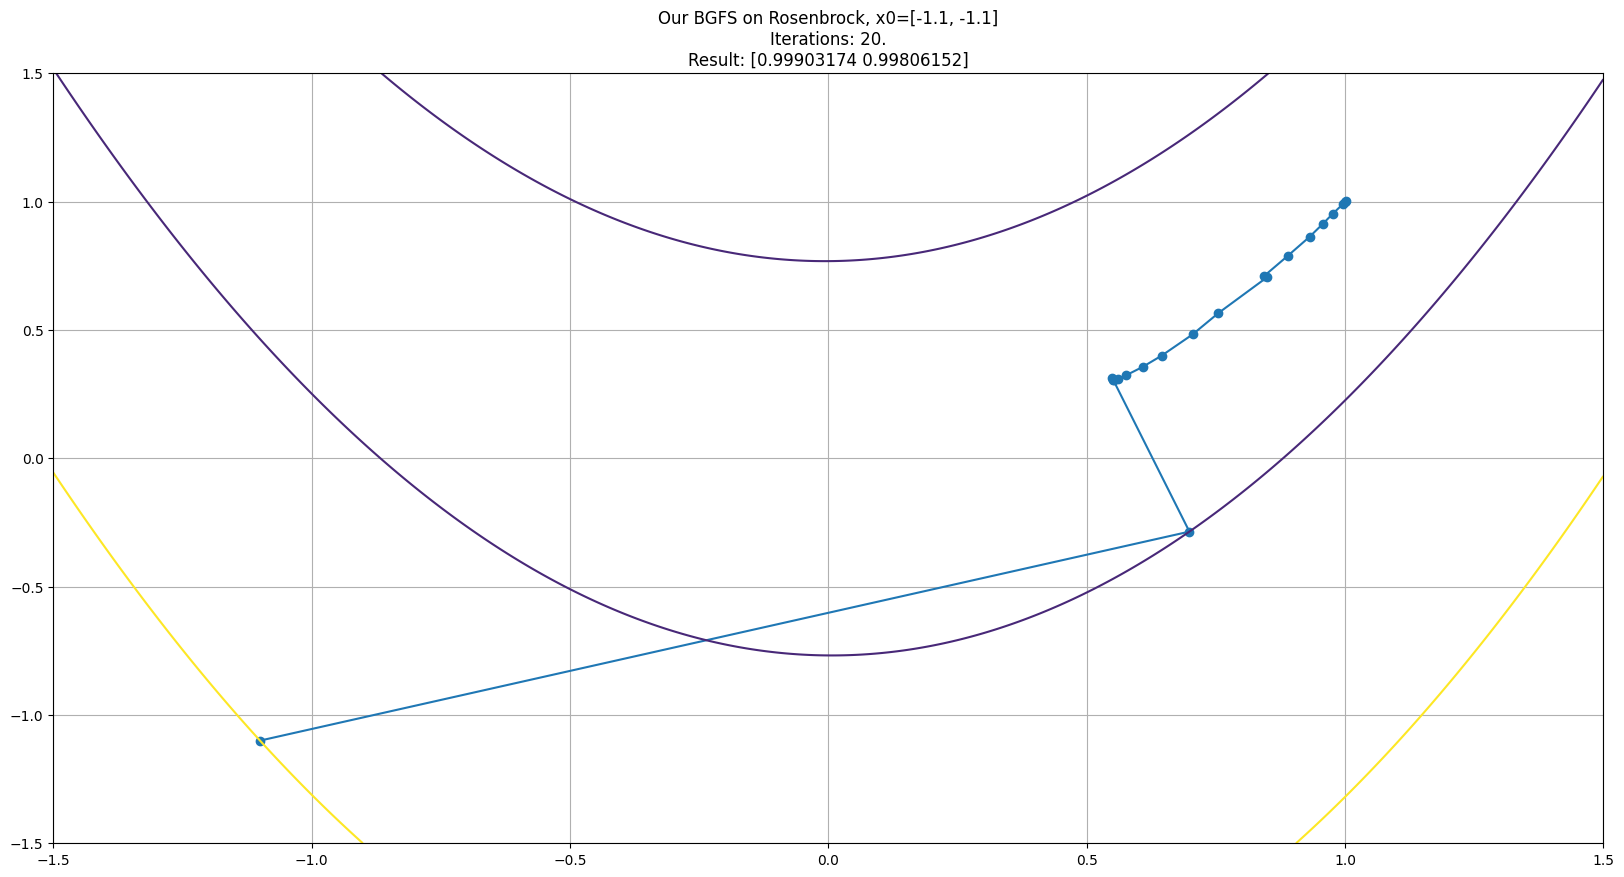

In [201]:
our_bgfs_points = bfgs(ros, numdiff_ros_grad, x0)
draw_level_lines(ros, plt, our_bgfs_points, left=-1.5, right=1.5, title=f"Our BGFS on Rosenbrock, x0={x0}")

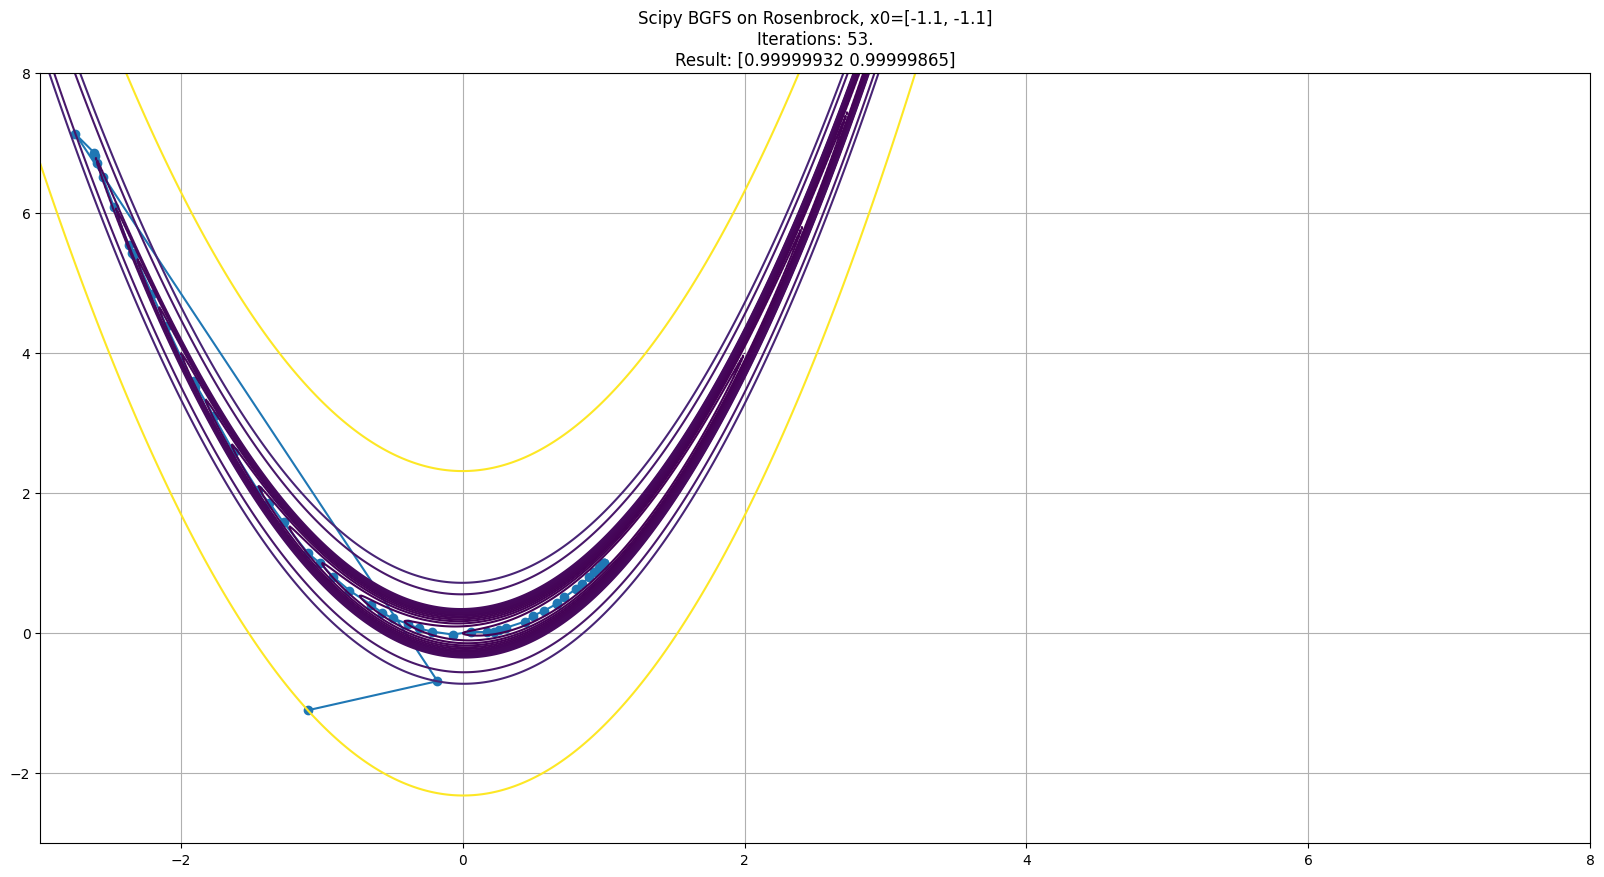

In [202]:
sci_bgfs_points = [x0]
opt.minimize(method='BFGS', fun=ros, jac=numdiff_ros_grad, x0=x0, tol=EPS,
             callback=lambda p: sci_bgfs_points.append(p))
draw_level_lines(ros, plt, sci_bgfs_points, left=-3, right=8, title=f"Scipy BGFS on Rosenbrock, x0={x0}")

Метод из библиотеки scipy на минимизации функции Розенброка на первом шаге сильно уходит в какую-то сторону, что в последствии дает больше итераций.

#### Исследование на функции Била

$${f(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$$

С минимумом в точке $f(3,0.5)=0$

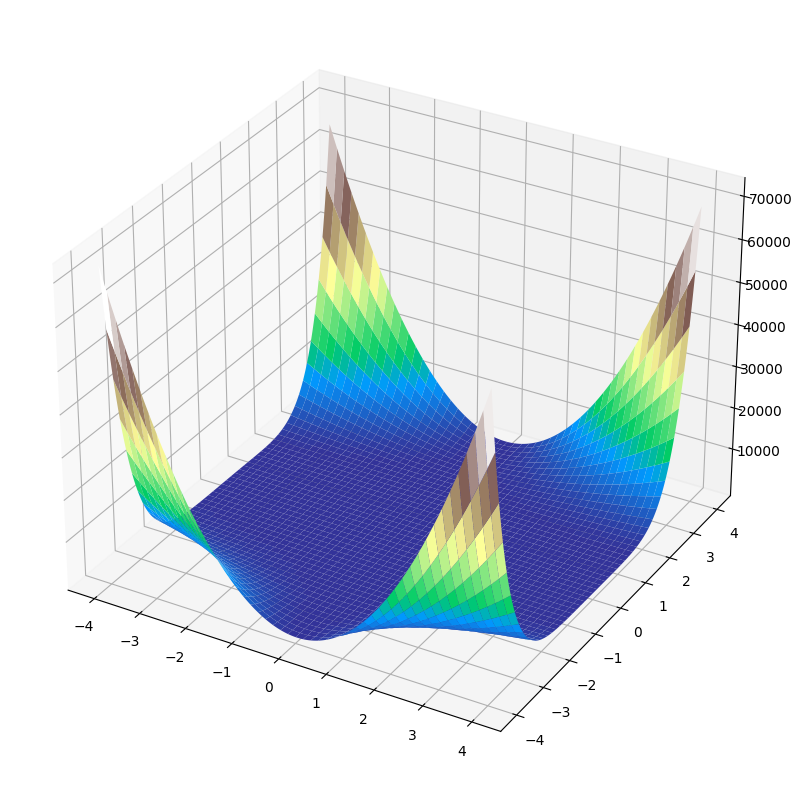

In [203]:
def beale(x):
    return (1.5 - x[0] + x[0] * x[1]) ** 2 + (2.25 - x[0] + x[0] * x[1] ** 2) ** 2 + (
            2.625 - x[0] + x[0] * x[1] ** 3) ** 2


numdiff_beale_grad = gradient(beale)
draw_f(beale)

In [204]:
x0 = [1., 1.]

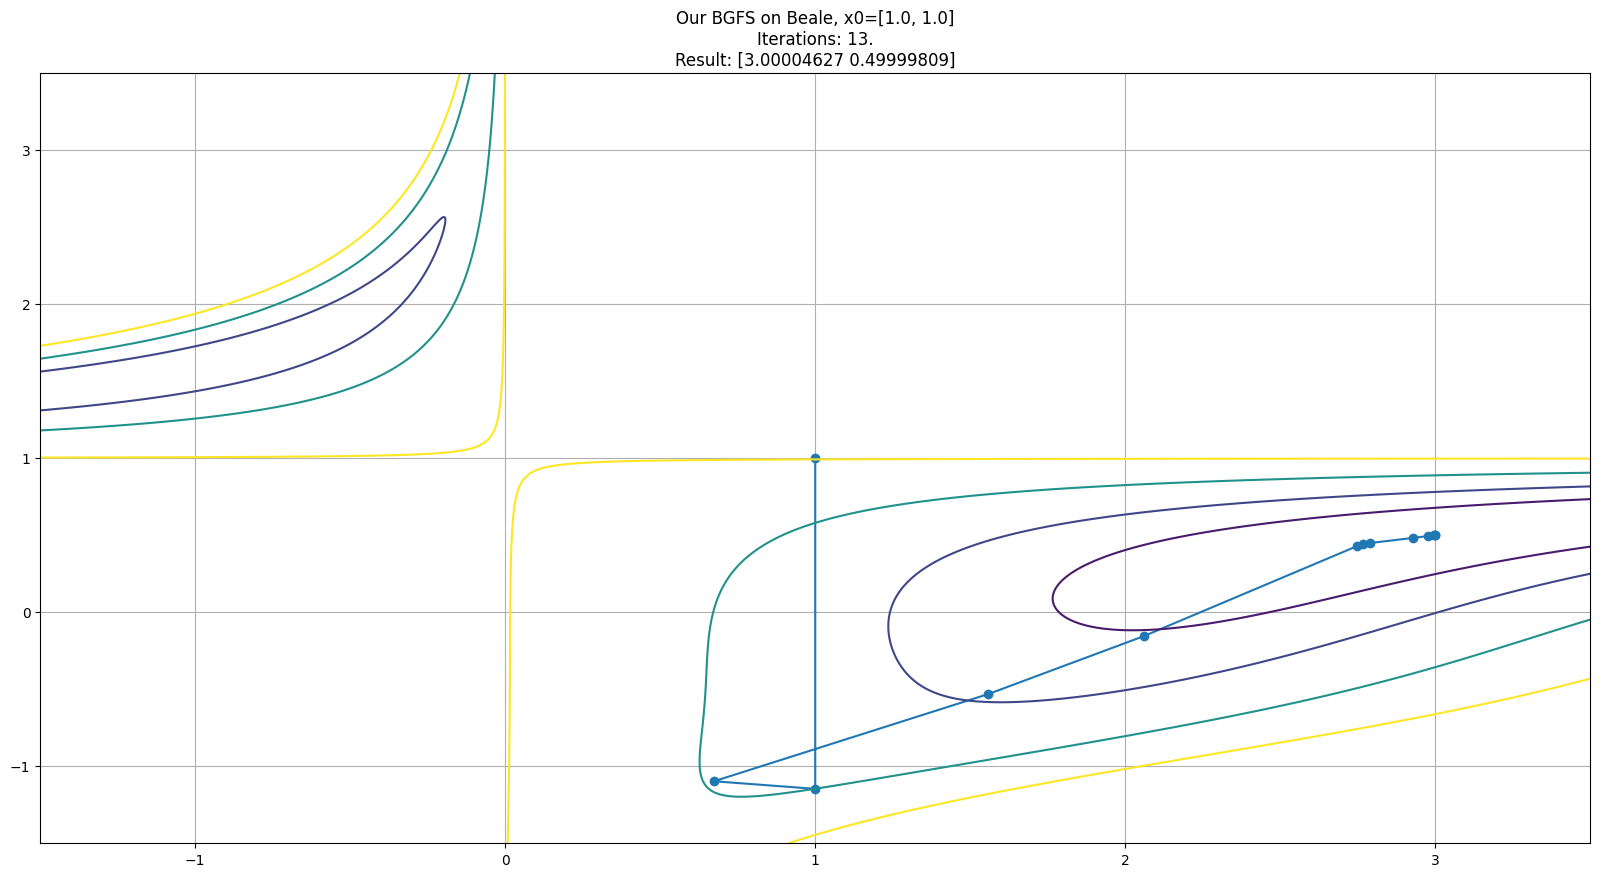

In [205]:
our_bgfs_points = bfgs(beale, numdiff_beale_grad, x0)
draw_level_lines(beale, plt, our_bgfs_points, left=-1.5, right=3.5, title=f"Our BGFS on Beale, x0={x0}")

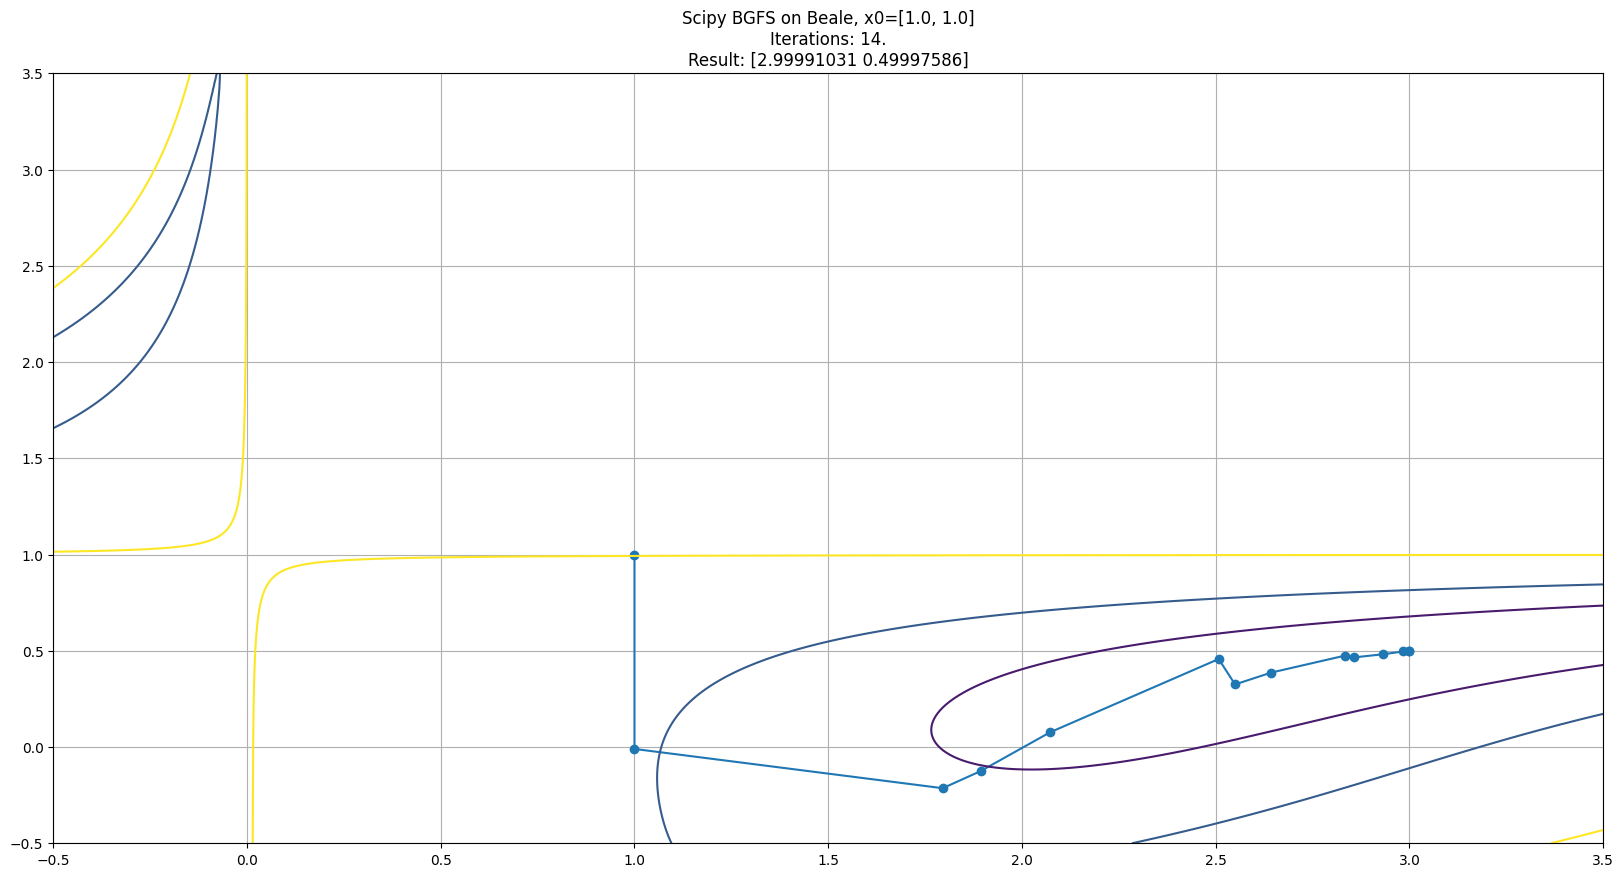

In [206]:
sci_bgfs_points = [x0]
opt.minimize(method='BFGS', fun=beale, jac=numdiff_beale_grad, x0=x0, tol=EPS,
             callback=lambda p: sci_bgfs_points.append(p))
draw_level_lines(beale, plt, sci_bgfs_points, left=-0.5, right=3.5, title=f"Scipy BGFS on Beale, x0={x0}")

Отодвинем начальную точку

In [207]:
x0 = [-1., -2.]

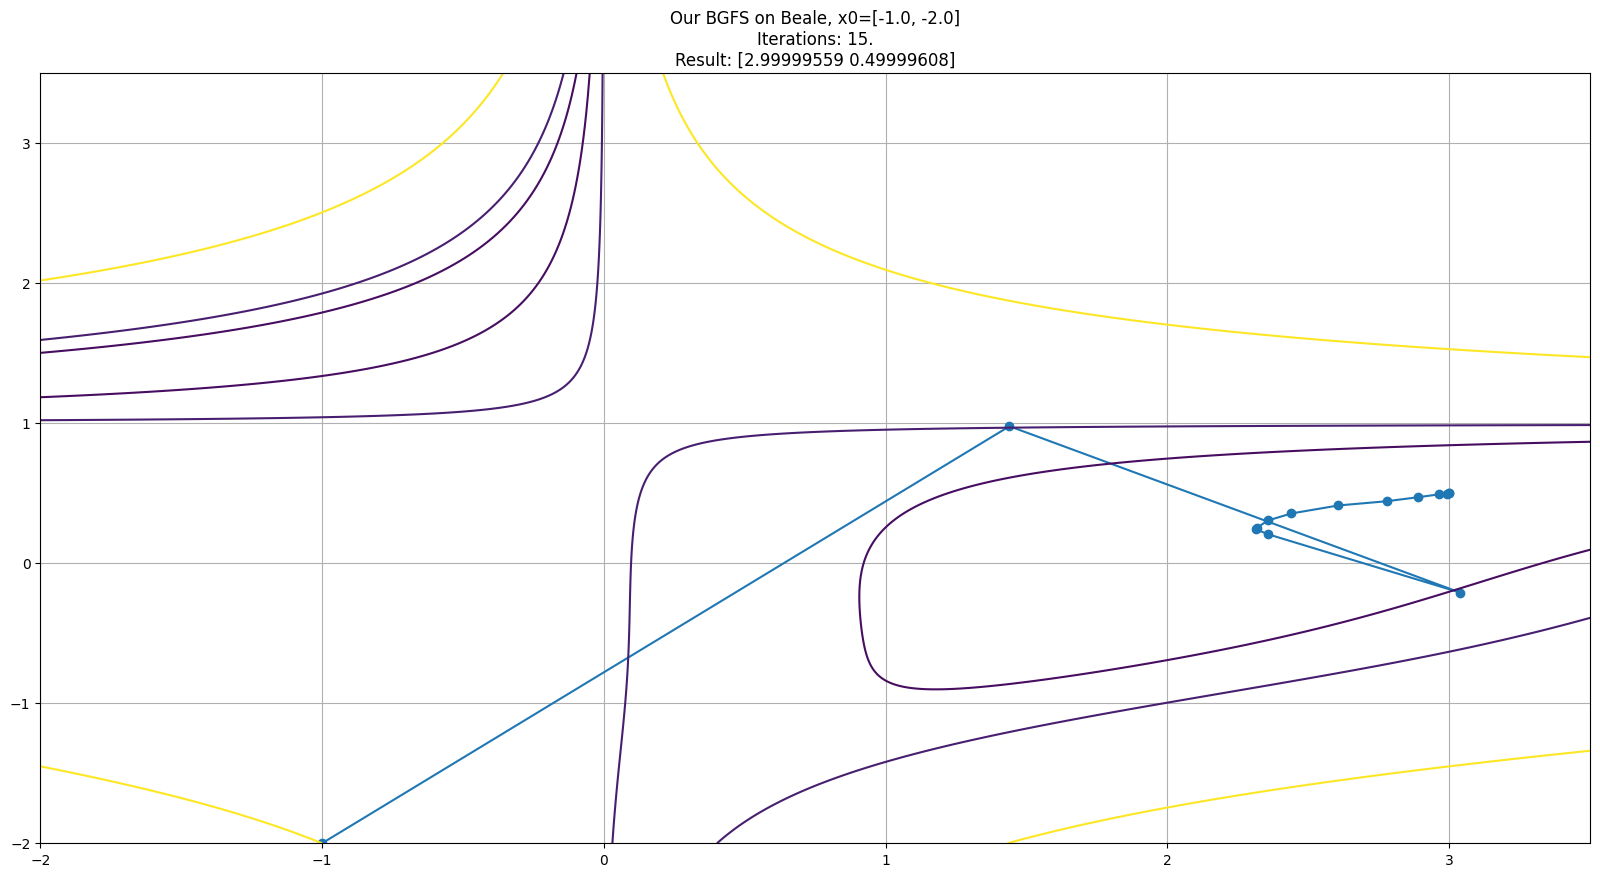

In [208]:
our_bgfs_points = bfgs(beale, numdiff_beale_grad, x0)
draw_level_lines(beale, plt, our_bgfs_points, left=-2, right=3.5, title=f"Our BGFS on Beale, x0={x0}")

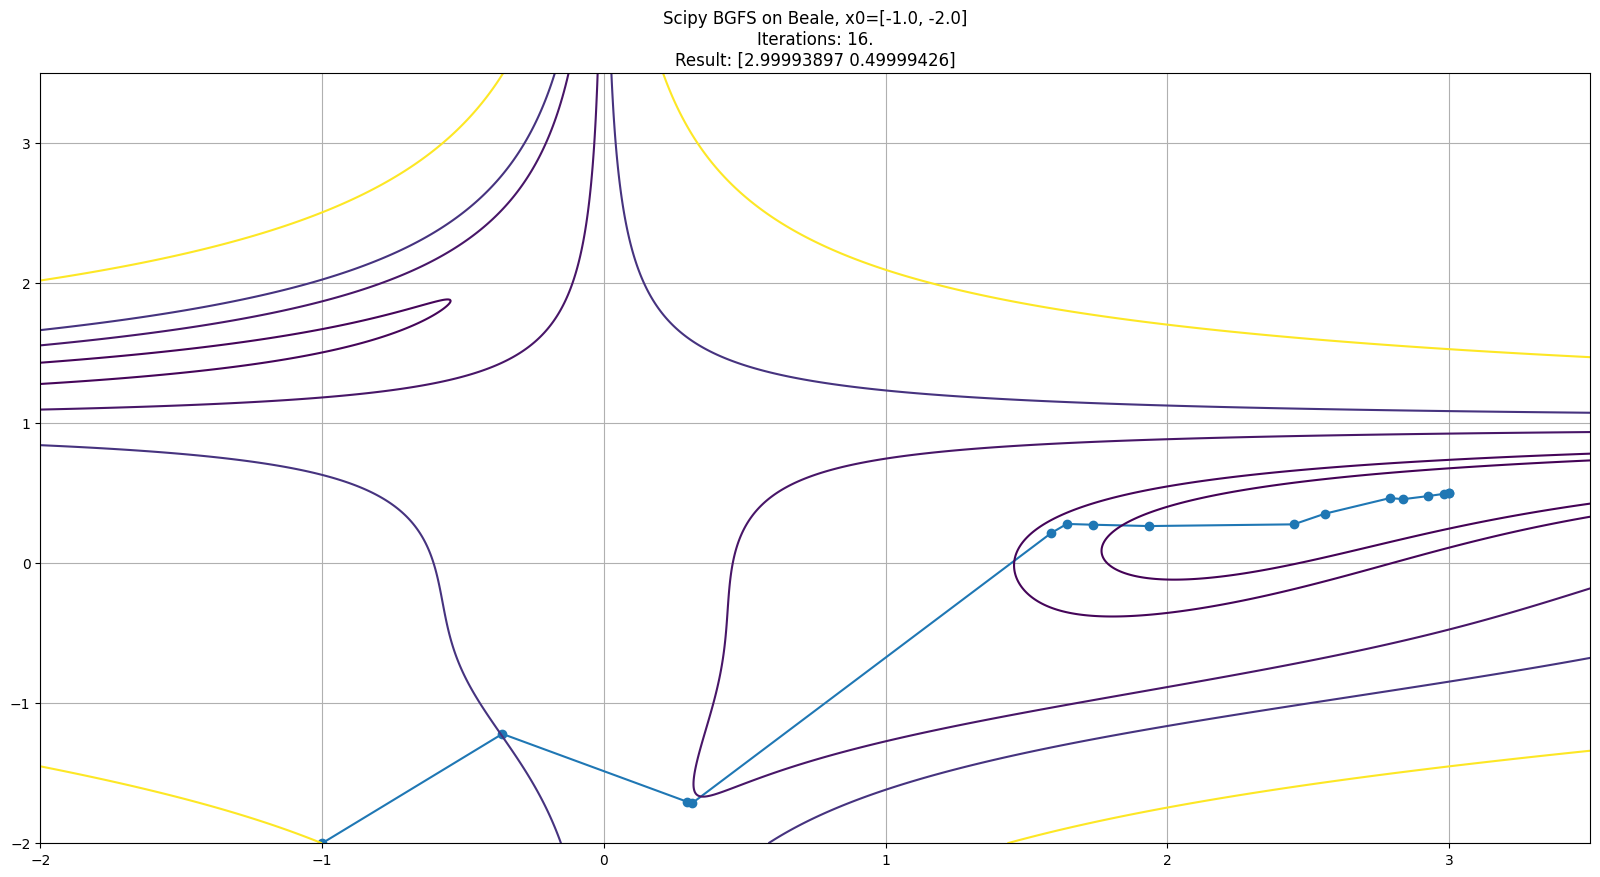

In [209]:
sci_bgfs_points = [x0]
opt.minimize(method='BFGS', fun=beale, jac=numdiff_beale_grad, x0=x0, tol=EPS,
             callback=lambda p: sci_bgfs_points.append(p))
draw_level_lines(beale, plt, sci_bgfs_points, left=-2, right=3.5, title=f"Scipy BGFS on Beale, x0={x0}")

Как видно по графикам реализованная нами функция сходится быстрее из-за больших скачков.

### Сравнение написанного Gauss-Newton, Newton-CG из scipy.minimize и Dogbox из scipy.least_squares

Сравним на решении нелинейной регрессии.

#### Gauss-Newton из 3-й лабораторной

In [210]:
def numdiff_indexed(f, x, i, indexes, delta=DELTA):
    plus_delta = x.copy()
    plus_delta[i] += delta
    minus_delta = x.copy()
    minus_delta[i] -= delta
    return (f(plus_delta, indexes) - f(minus_delta, indexes)) / (2 * delta)


def grad_indexed(f, x, i, indexes):
    return numdiff_indexed(f, x, i, indexes)


def orienting(x):
    A = list()
    for i in range(len(x)):
        row = list()
        for j in range(300):
            row.append(grad_indexed(nolinear_sum, x, i, [j]))
        A.append(row)
    J = np.array(A).T
    r = list()
    for i in range(300):
        r.append(nolinear_sum(x, [i]))
    result_p = -np.linalg.inv(J.T @ J) @ J.T @ np.array(r).T
    return result_p


def newton(f, grad_f, start, max_epoch=1000, tol=EPS):
    point = start
    points = list()
    loss = list()
    points.append(start)
    loss.append(f(start))

    for i in range(1, max_epoch):
        p = orienting(point)
        lr = opt.line_search(f, grad_f, point, p)[0]
        point = point + lr * np.array(p)
        points.append(point)
        loss.append(f(point))

        if np.linalg.norm(grad_f(point)) < tol:
            break

    return np.array(points), loss


#### Функция для исследования

$$f(x) = \frac{\pi ^ {-5 \cdot x} + 3 \cdot x}{1 + 4 \cdot x}$$

In [211]:
def func(x, a1, a2, a3, a4):
    return (np.pi ** (-a1 * x) + a2 * x) / (a3 + a4 * x)


def minimizing_func(a):
    return np.sum((func(xs, *a) - ys) ** 2)


def residual(a):
    return func(xs, *a) - ys


def nolinear_sum(a, indexes=range(300)):
    sum = 0
    for i in indexes:
        sum += (func(xs[i], *a) - ys[i]) ** 2
    return sum

In [212]:
start_point = [6, 4, 2, 5]
result_point = [5, 3, 1, 4]
xs = np.linspace(0, 10, 300)
ys = func(xs, *result_point)

In [213]:
newton_points, newton_loss = newton(nolinear_sum, gradient(nolinear_sum), start_point)
newton_x = newton_points[-1]

In [214]:
ncg_loss = [minimizing_func(start_point)]
ncg_result = opt.minimize(fun=minimizing_func, x0=start_point, method='Newton-CG', tol=EPS,
                          jac=gradient(minimizing_func), callback=lambda p: ncg_loss.append(minimizing_func(p)))
ncg_x = ncg_result.x

In [215]:
db_result = opt.least_squares(residual, x0=start_point, method='dogbox', gtol=EPS, xtol=EPS, ftol=EPS)
db_res = db_result.x
db_loss = db_result.fun

Gauss-Newton
	Iterations: 13
	Result: [5.00021062 2.99988508 1.00000164 3.99981194]
Newton-CG
	Iterations: 10
	Result: [5.18895896 3.07804667 0.99442441 4.11158983]
Dog-box
	Iterations: ?
	Result: [5.00000509 2.99999115 0.99999624 3.99998836]


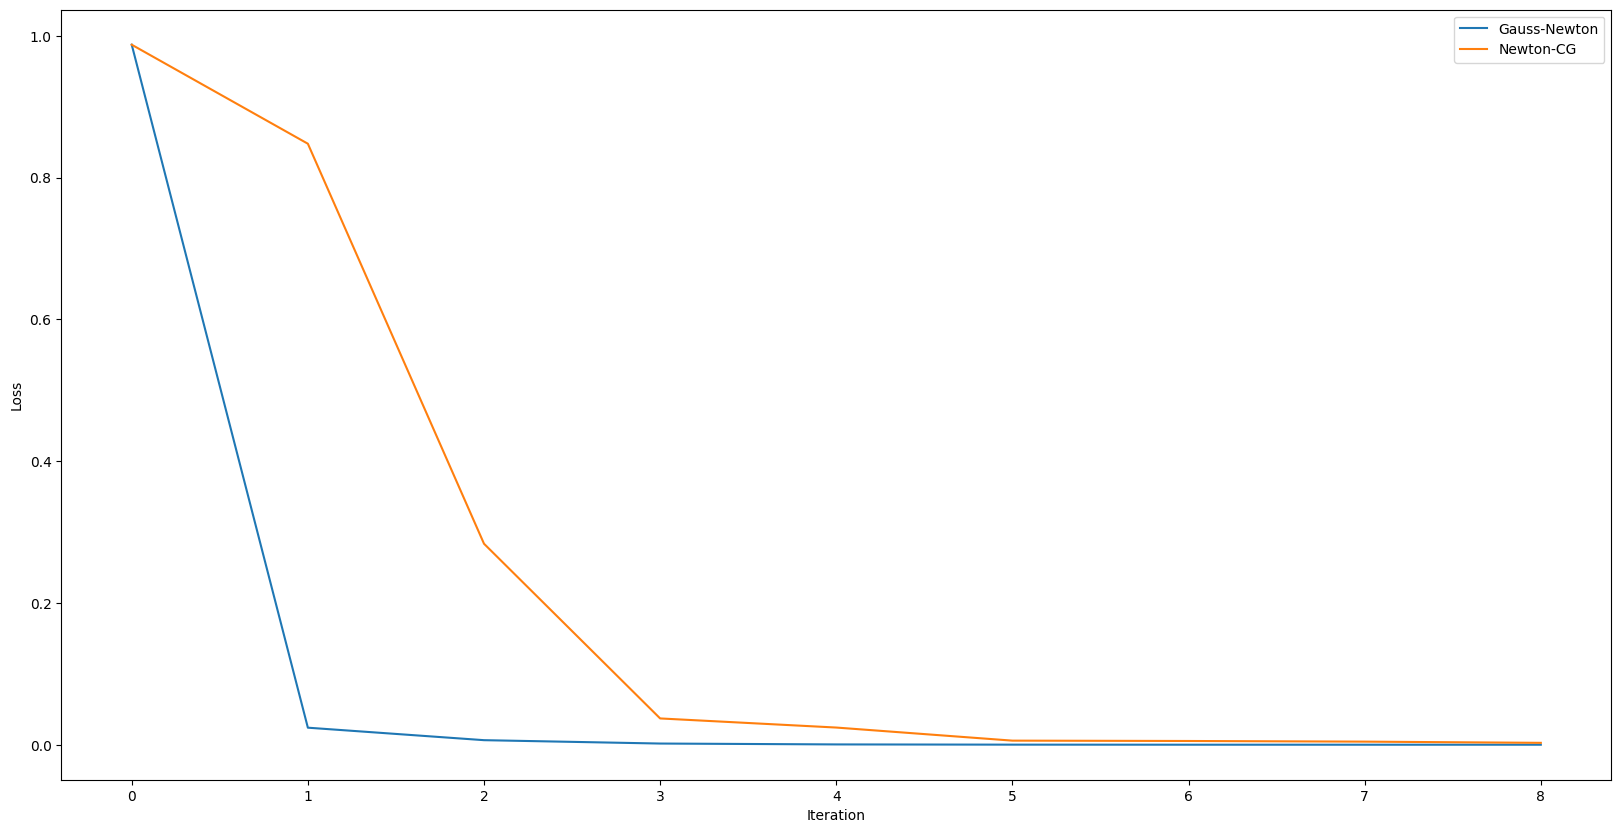

In [216]:
print(f'Gauss-Newton\n\tIterations: {len(newton_loss)}\n\tResult: {newton_x}')
print(f'Newton-CG\n\tIterations: {len(ncg_loss)}\n\tResult: {ncg_x}')
print(f'Dog-box\n\tIterations: ?\n\tResult: {db_res}')

size = min(len(newton_loss), len(db_loss), len(ncg_loss)) - 1
x = range(0, size)

plt.plot(x, newton_loss[:size], label=f'Gauss-Newton')
plt.plot(x, ncg_loss[:size], label=f'Newton-CG')
# plt.plot(x, db_loss[:size], label=f'Dog-box')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

В сравнении между Gauss-Newton и Newton-CG библиотечный метод сошелся чуть быстрее, но выдал плохую точность. По графику зависимости значения функции потерь от итерации реализованный вручную метод с самого начала быстрее приблизился к 0.

К сожалению, нам не удалось понять, как найти промежуточные значения функции у least_squares и построить по ним график. Поэтому просто выведем то, что получилось в результате

In [217]:
print(db_result)

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 3.760e-06  2.587e-06 ... -1.309e-08 -1.314e-08]
           x: [ 5.000e+00  3.000e+00  1.000e+00  4.000e+00]
        cost: 1.4145559128702152e-11
         jac: [[ 0.000e+00  0.000e+00 -1.000e+00  0.000e+00]
               [-2.788e-02  2.950e-02 -7.205e-01 -2.410e-02]
               ...
               [ 0.000e+00  2.439e-01 -1.790e-02 -1.784e-01]
               [ 0.000e+00  2.439e-01 -1.785e-02 -1.785e-01]]
        grad: [-3.599e-07  1.387e-06 -8.756e-06 -8.133e-07]
  optimality: 8.756468566294774e-06
 active_mask: [0 0 0 0]
        nfev: 7
        njev: 6


### Сравним разные градиенты для методов из scipy

Исследуем на методе BFGS

#### Сравним на решении нелинейной регрессии.

$$f(x) = \frac{\pi ^ {-5 \cdot x} + 3 \cdot x}{1 + 4 \cdot x}$$

Градиент с помощью pytorch

In [218]:
def minimizing_func_tensor(a):
    res = torch.tensor([0.])
    for i in range(300):
        res += (func(xs[i], a[0], a[1], a[2], a[3]) - ys[i]) ** 2
    return res


def func_with_grad(pars):
    pars = torch.tensor(pars, requires_grad=True)
    y = minimizing_func_tensor(pars)
    res = y.sum()
    res.backward()
    return res.data.cpu().numpy(), pars.grad.data.cpu().numpy()


In [219]:
torch_loss = [minimizing_func(start_point)]
torch_result = opt.minimize(func_with_grad, start_point, method='BFGS', jac=True, tol=EPS,
                            callback=lambda p: torch_loss.append(minimizing_func(p)))

In [220]:
nd_loss = [minimizing_func(start_point)]
nd_result = opt.minimize(fun=minimizing_func, x0=start_point, method='BFGS', tol=EPS, jac=gradient(minimizing_func),
                         callback=lambda p: nd_loss.append(minimizing_func(p)))

Pytorch grad
	Iterations: 19
	Result: [4.99712086 2.9999478  1.00017374 3.99991282]
Numdiff grad
	Iterations: 19
	Result: [4.99712034 2.99994799 1.00017379 3.99991309]


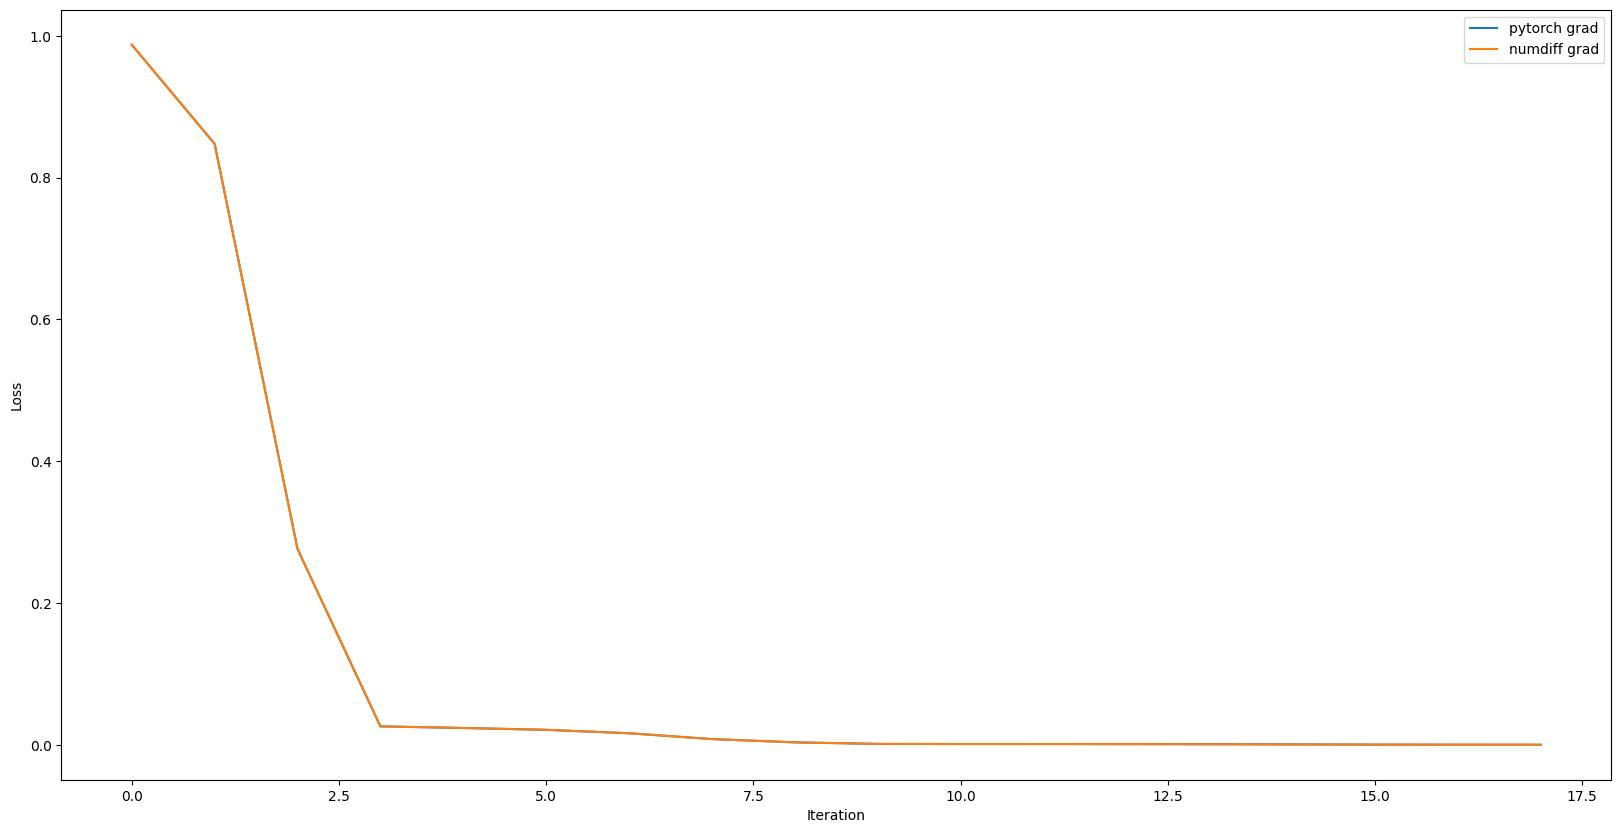

In [221]:
print(f'Pytorch grad\n\tIterations: {len(torch_loss)}\n\tResult: {torch_result.x}')
print(f'Numdiff grad\n\tIterations: {len(nd_loss)}\n\tResult: {nd_result.x}')

size = min(len(torch_loss), len(nd_loss)) - 1
x = range(0, size)

plt.plot(x, torch_loss[:size], label=f'pytorch grad')
plt.plot(x, nd_loss[:size], label=f'numdiff grad')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

Как видно для данной функции метод с использованием написанного градиента с помощью численного дифференцирования и с реализованным градиентом из PyTorch выдали одинаковый результат.

#### Сравним на поиске минимума для функции Розенброка

$$f(x,y)=(1-x)^2+100(y-x^2)^2$$

In [236]:
x0 = [-1.1, -1.1]

Добавим в сравнение градиент по определению

In [237]:
def ros_grad(x):
    return np.array([
        -400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0]),
        200 * (x[1] - x[0] ** 2)
    ])

In [238]:
def_loss = [ros(start_point)]
def_result = opt.minimize(ros, x0=x0, method='BFGS', jac=ros_grad, tol=EPS,
                          callback=lambda p: def_loss.append(ros(p)))

In [239]:
def ros_with_grad(x):
    x = torch.tensor(x, requires_grad=True)
    y = ros(x)
    y.backward()
    return y.data, x.grad

In [240]:
torch_loss = [ros(start_point)]
torch_result = opt.minimize(ros_with_grad, x0=x0, method='BFGS', jac=True, tol=EPS,
                            callback=lambda p: torch_loss.append(ros(p)))

In [241]:
nd_loss = [ros(start_point)]
nd_result = opt.minimize(ros, x0=x0, method='BFGS', jac=numdiff_ros_grad, tol=EPS,
                         callback=lambda p: nd_loss.append(ros(p)))

Definition grad
	Iterations: 56
	Result: [0.99999924 0.99999834]
Pytorch grad
	Iterations: 56
	Result: [0.99999924 0.99999834]
Numdiff grad
	Iterations: 56
	Result: [0.99998784 0.99997573]


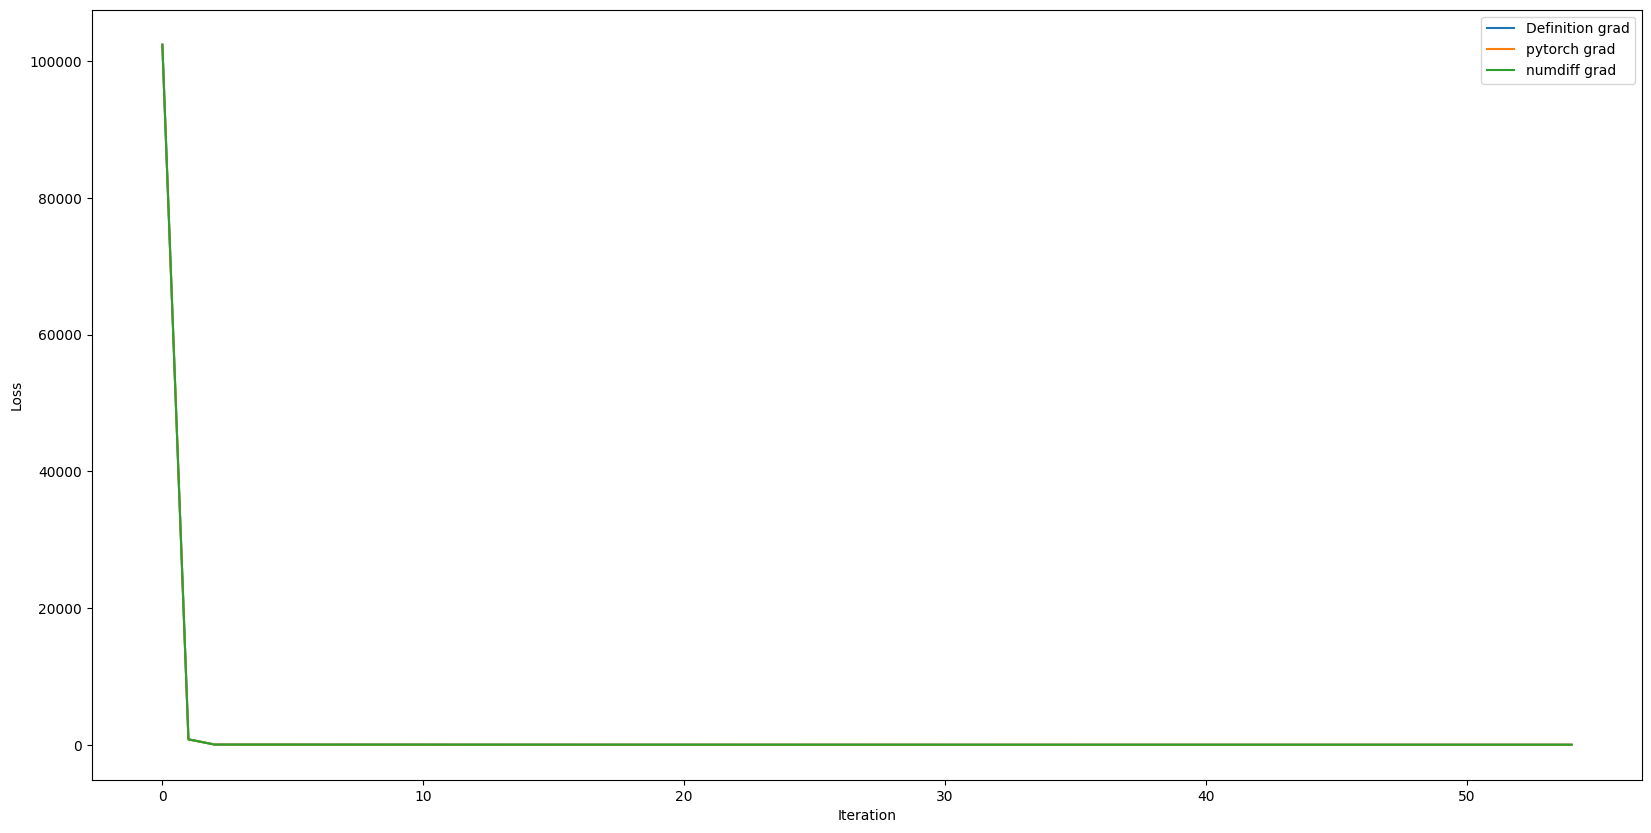

In [242]:
print(f'Definition grad\n\tIterations: {len(def_loss)}\n\tResult: {def_result.x}')
print(f'Pytorch grad\n\tIterations: {len(torch_loss)}\n\tResult: {torch_result.x}')
print(f'Numdiff grad\n\tIterations: {len(nd_loss)}\n\tResult: {nd_result.x}')

size = min(len(def_loss), len(torch_loss), len(nd_loss)) - 1
x = range(0, size)

plt.plot(x, def_loss[:size], label=f'Definition grad')
plt.plot(x, torch_loss[:size], label=f'pytorch grad')
plt.plot(x, nd_loss[:size], label=f'numdiff grad')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

Как видно по количеству итераций метод с численным дифференцированием совсем немного проигрывает градиенту по определению и через PyTorch tensor, которые выдали абсолютно одинаковый результат.

### Исследуем на влияние задания границ изменения параметров на методы из SciPy

Проведем исследования на обычном BFGS и L-BFGS-B, последний из котороый поддерживает задание границ. Найдем минимум для функции Розенброка.


Отодвинем начальную точку достаточно далеко

In [292]:
x0 = [-2., -2.]

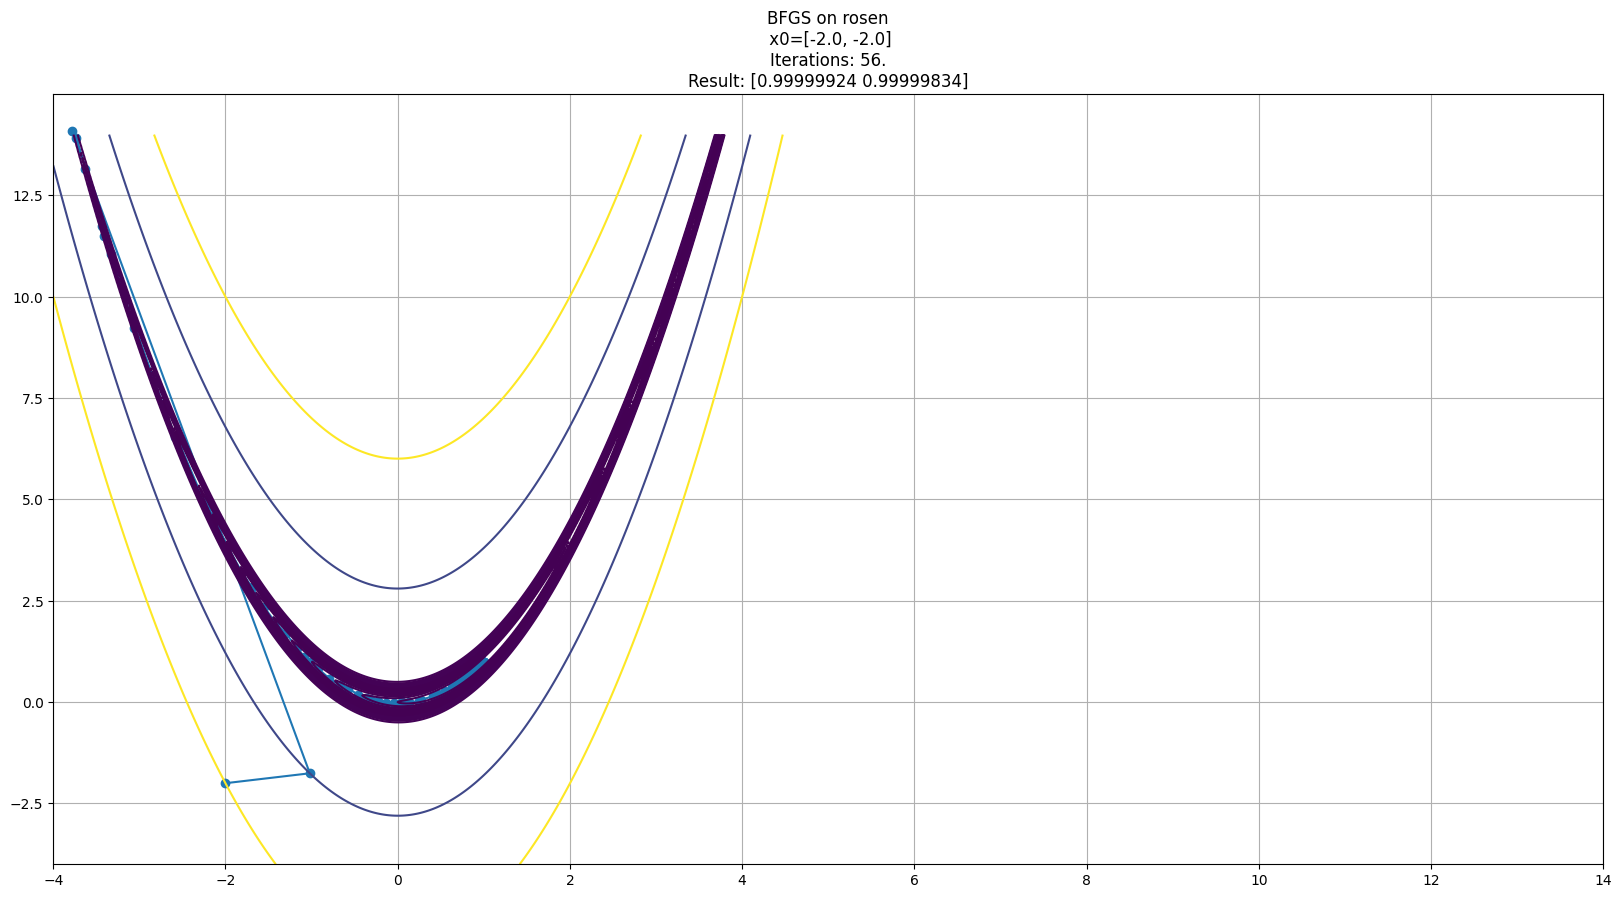

In [293]:
bfgs_points = [x0]
opt.minimize(fun=ros, x0=x0, method='BFGS', jac=ros_grad, tol=EPS,
             callback=lambda p: bfgs_points.append(p))
draw_level_lines(ros, plt, bfgs_points, left=-4, right=14, title=f"BFGS on rosen\n x0={x0}")

Обычный BFGS на функции с узким минимум с самого начала ушел не туда, поэтому ему пришлось тратить больше итераций.

In [294]:
bounds = [(-3, 3)]

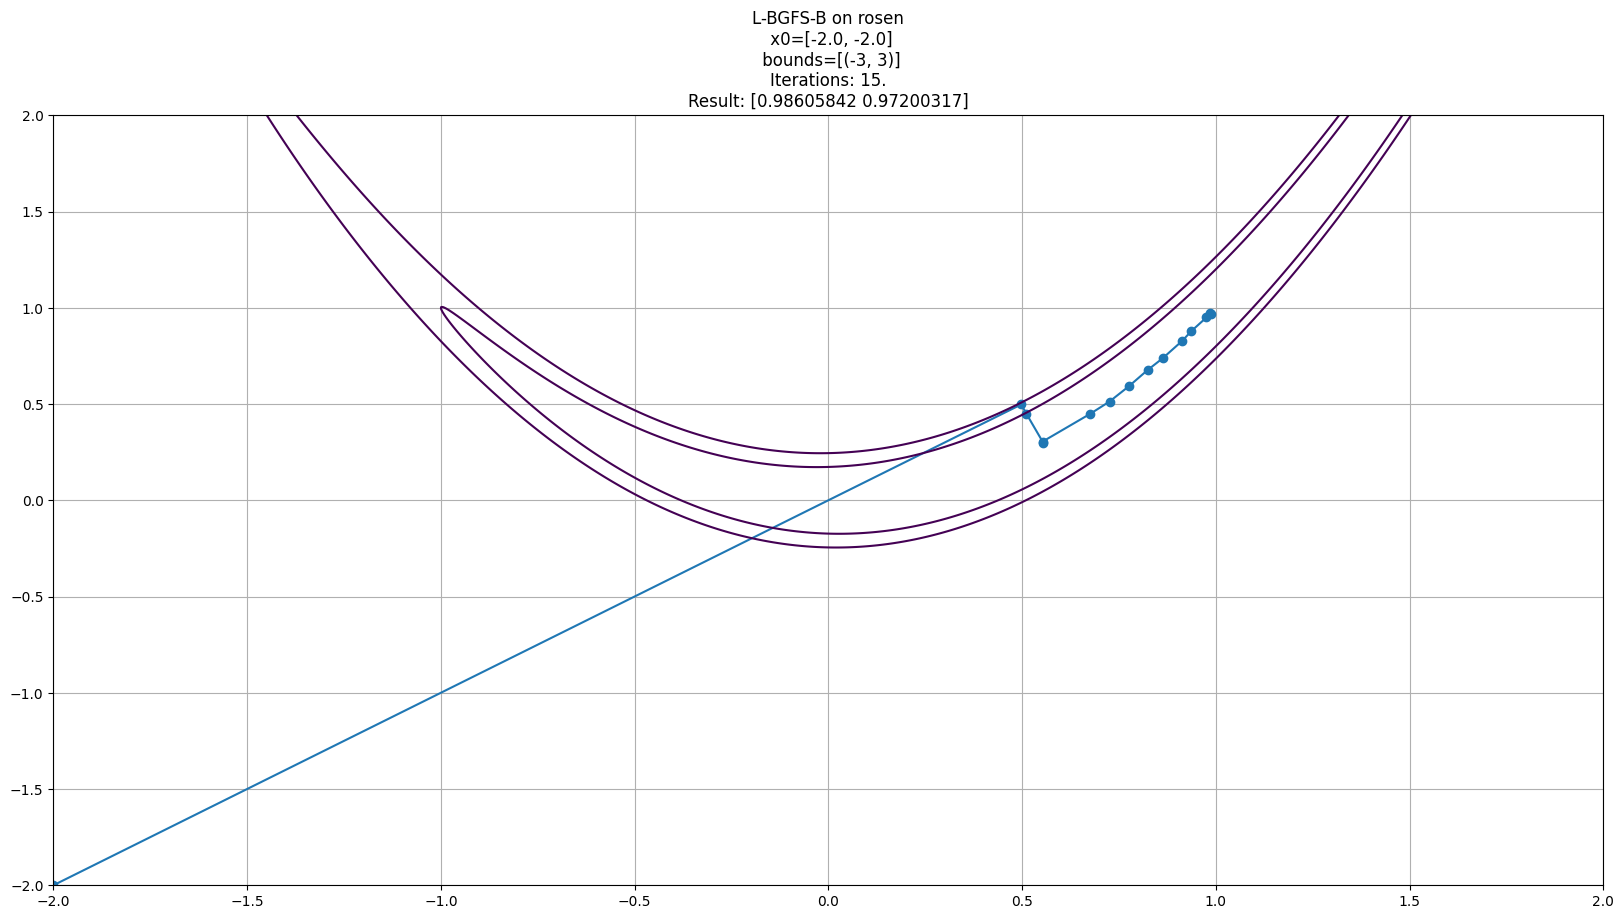

In [295]:
lbfgsb_points = [x0]
opt.minimize(fun=ros, x0=x0, method='L-BFGS-B', bounds=bounds, jac=ros_grad, tol=EPS,
             callback=lambda p: lbfgsb_points.append(p))
draw_level_lines(ros, plt, lbfgsb_points, left=-2, right=2, title=f"L-BGFS-B on rosen\n x0={x0}\n bounds={bounds}")

Из-за ограничений L-BFGS-B сразу начал двигаться в нужном направлении, но при этом почему-то потерялась точность.

Немного расширим диапазон

In [296]:
bounds = [(-5, 5)]

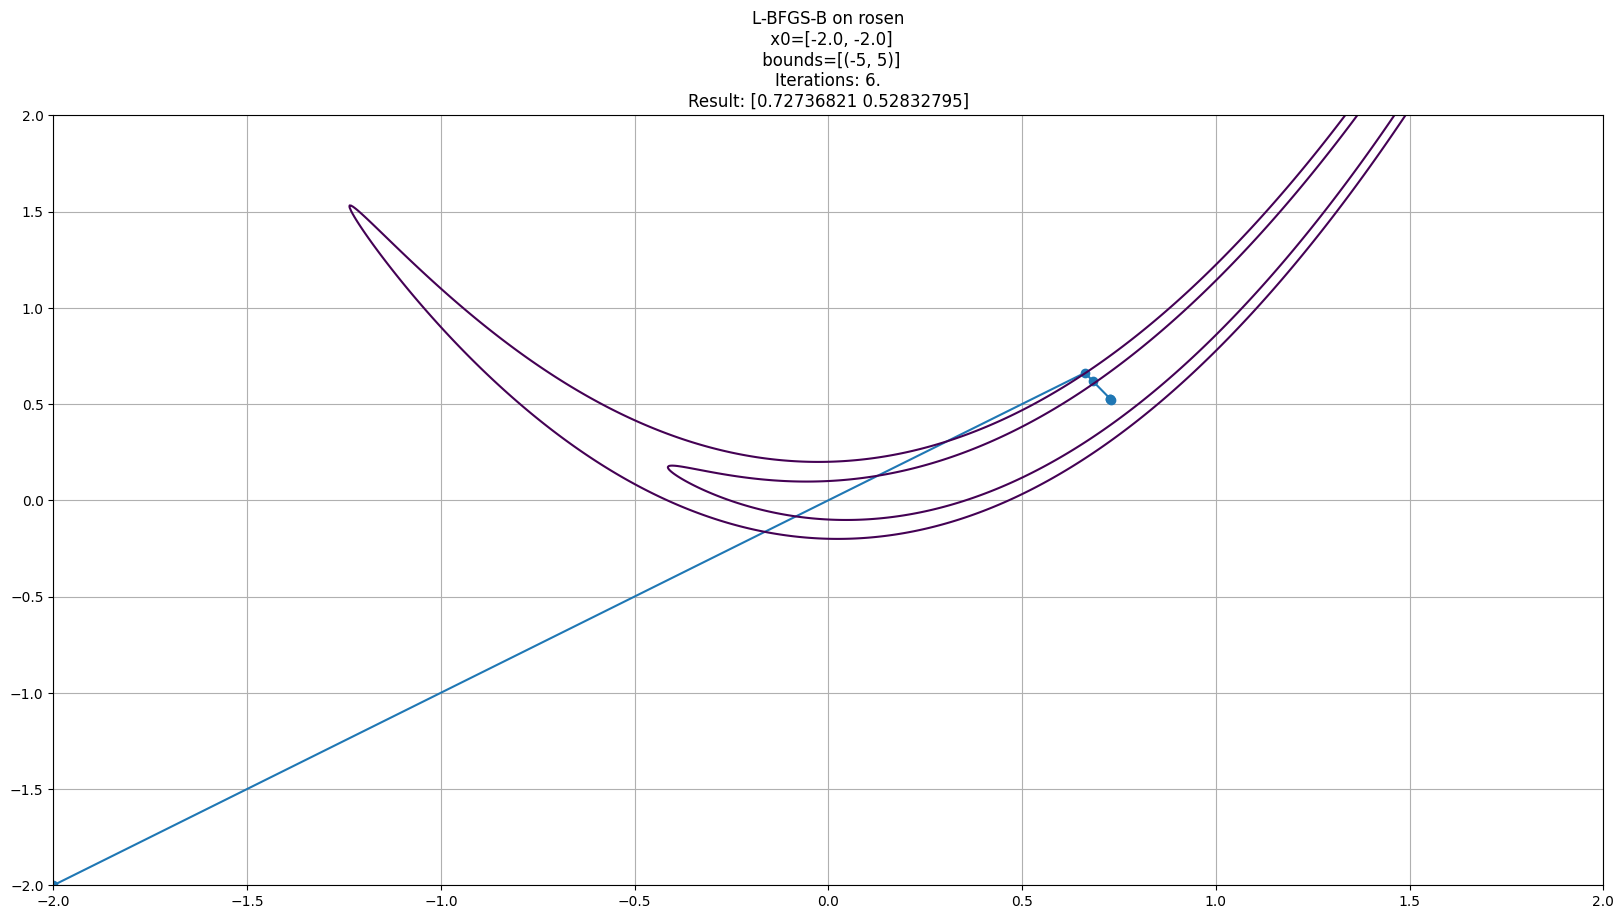

In [297]:
lbfgsb_points = [x0]
opt.minimize(fun=ros, x0=x0, method='L-BFGS-B', bounds=bounds, jac=ros_grad, tol=EPS,
             callback=lambda p: lbfgsb_points.append(p))
draw_level_lines(ros, plt, lbfgsb_points, left=-2, right=2, title=f"L-BFGS-B on rosen\n x0={x0}\n bounds={bounds}")

С таким диапазоном мы совсем потеряли точность. Попробуем уменьшить tolerance до $10^{-5}$ (напоминаю, что до этого она всегда была $\varepsilon = 10^{-3}$)

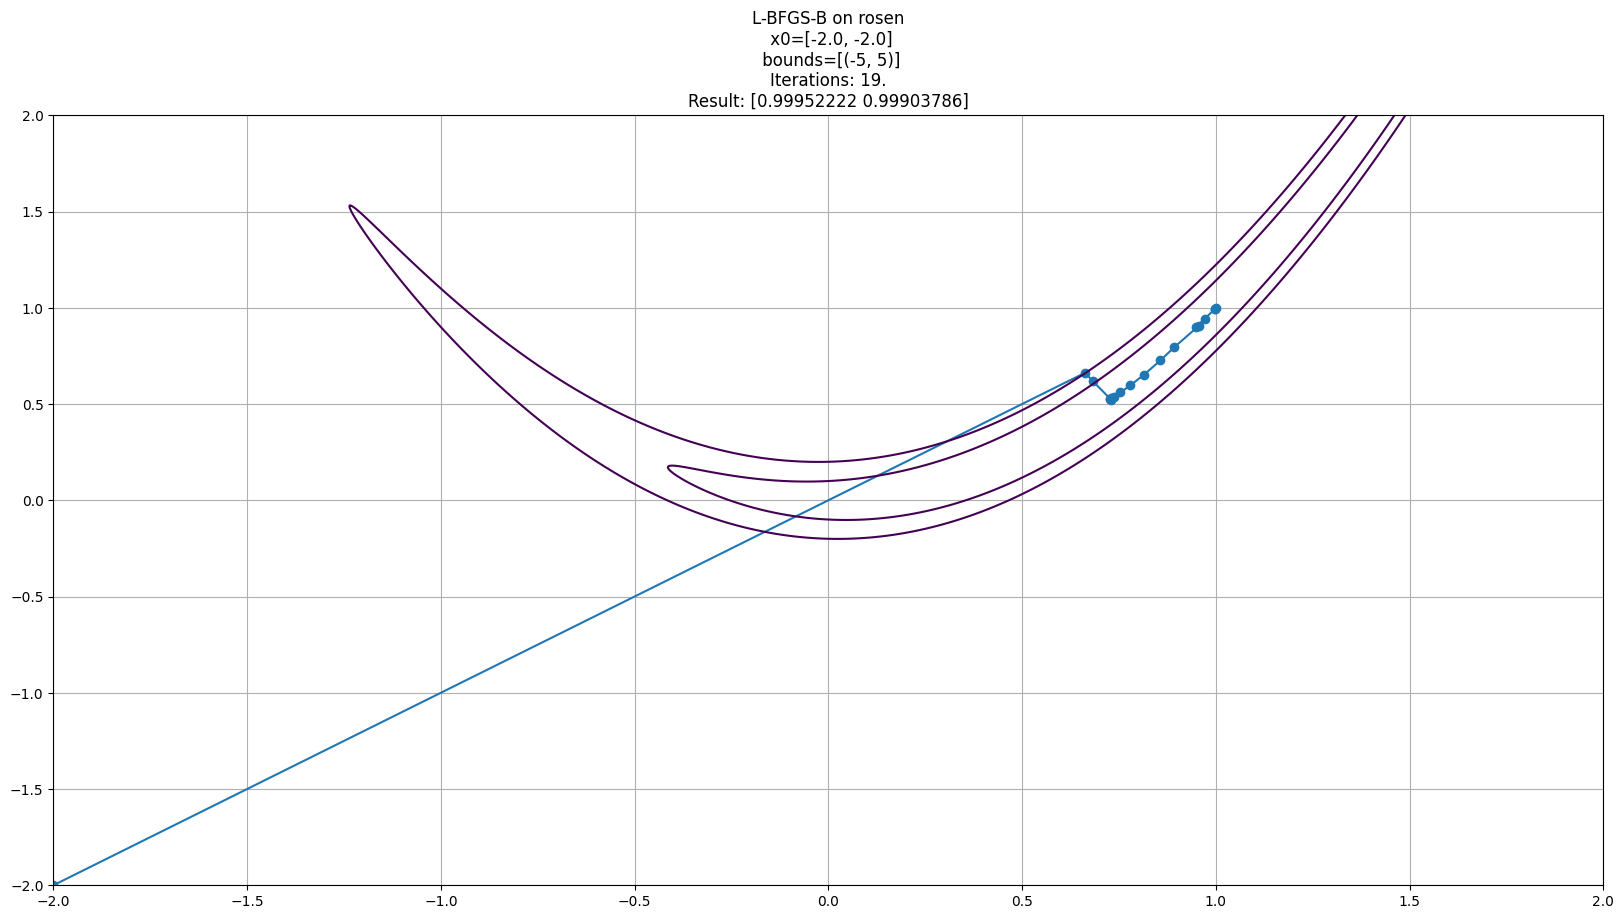

In [298]:
lbfgsb_points = [x0]
opt.minimize(fun=ros, x0=x0, method='L-BFGS-B', bounds=bounds, jac=ros_grad, tol=10e-5,
             callback=lambda p: lbfgsb_points.append(p))
draw_level_lines(ros, plt, lbfgsb_points, left=-2, right=2, title=f"L-BFGS-B on rosen\n x0={x0}\n bounds={bounds}")

Полученный результат приемлемый, количество итераций достаточно мало.